<a href="https://colab.research.google.com/github/tanyatibouche/Screw-Project2/blob/main/test_amelia_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unrar x screw_dataset.rar screw_dataset


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from screw_dataset.rar

Creating    screw_dataset                                             OK
Creating    screw_dataset/bad                                         OK
Extracting  screw_dataset/bad/000_png.rf.150d97f3842bae43d25e38ddd985ce0d.jpg       0%  OK 
Extracting  screw_dataset/bad/000_png.rf.1578c55ecab605301b94780b6bb22f2a.jpg       0%  OK 
Extracting  screw_dataset/bad/000_png.rf.22875d4dc4b40c0f5ecc9eea46a92c02.jpg       0%  OK 
Extracting  screw_dataset/bad/000_png.rf.23a40510a9136ea9ee3c91214536fe9a.jpg       0%  OK 
Extracting  screw_dataset/bad/000_png.rf.3671a876707bdaa523ee0d403606486b.jpg       0%  OK 
Extracting  screw_dataset/bad/000_png.rf.3f62fb50fe144f40fa1e79e715459232.jpg       0%  OK 
Extracting  screw_dataset/bad/000_png.rf.6576630d03abce02c855fdd9ee9f4321.jpg       0%  OK 
Extracting  screw_dataset/bad/000_pn

In [26]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, F1Score
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img, ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

print("Using TensorFlow version:", tf.__version__)

# Pour reproduire un comportement stable (optionnel)
tf.random.set_seed(42)

Using TensorFlow version: 2.18.0


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pathlib

# Configuration
DATA_DIR = "./screw_dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42
TEST_RATIO = 0.15
VAL_RATIO = 0.15

# --------------------------------------------------
# Étape 1: Chargement et division des données
# --------------------------------------------------
def load_and_split_data():
    print("\n" + "="*50)
    print("Chargement et division des données...")

    # Lister tous les fichiers avec leurs labels
    data_dir = pathlib.Path(DATA_DIR)
    all_files = list(data_dir.glob('*/*.jpg'))  # Adaptez l'extension si nécessaire
    classes = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])

    print(f"\nStructure détectée:")
    for cls in classes:
        print(f"- {cls}: {len(list(data_dir.glob(cls+'/*')))} images")

    # Création des labels
    file_paths = [str(f) for f in all_files]
    labels = [classes.index(pathlib.Path(f).parent.name) for f in file_paths]

    # Division stratifiée en train/test/val
    X_train, X_temp, y_train, y_temp = train_test_split(
        file_paths, labels,
        test_size=(TEST_RATIO + VAL_RATIO),
        stratify=labels,
        random_state=SEED
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=TEST_RATIO/(TEST_RATIO + VAL_RATIO),
        stratify=y_temp,
        random_state=SEED
    )

    print(f"\nTaille des datasets:")
    print(f"- Entraînement: {len(X_train)} images")
    print(f"- Validation: {len(X_val)} images")
    print(f"- Test: {len(X_test)} images")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# --------------------------------------------------
# Étape 2: Création des datasets TensorFlow
# --------------------------------------------------
def create_tf_dataset(file_paths, labels):
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --------------------------------------------------
# Étape 3: Analyse et visualisation
# --------------------------------------------------
def analyze_split(X, y, set_name):
    class_counts = np.bincount(y)
    total = len(y)

    print(f"\nAnalyse de {set_name}:")
    for i, count in enumerate(class_counts):
        print(f"- Classe {i}: {count} ({count/total:.1%})")

# --------------------------------------------------
# Étape 4: Pipeline complet
# --------------------------------------------------
def full_data_pipeline():
    # Division des données
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_split_data()

    # Analyse des splits
    analyze_split(X_train, y_train, "Train")
    analyze_split(X_val, y_val, "Validation")
    analyze_split(X_test, y_test, "Test")

    # Création des datasets
    train_ds = create_tf_dataset(X_train, y_train)
    val_ds = create_tf_dataset(X_val, y_val)
    test_ds = create_tf_dataset(X_test, y_test)

    return train_ds, val_ds, test_ds

# --------------------------------------------------
# Data Augmentation corrigée
# --------------------------------------------------
def augment_minority_class(dataset, minority_class):
    # Désassembler les batches et filtrer les éléments individuels
    def filter_minority(x, y):
        return tf.equal(y, minority_class)

    def filter_majority(x, y):
        return tf.not_equal(y, minority_class)

    # Séparer les classes
    minority_ds = dataset.unbatch().filter(filter_minority)
    majority_ds = dataset.unbatch().filter(filter_majority)

    # Calculer le besoin d'augmentation
    minority_count = len(list(minority_ds.as_numpy_iterator()))
    majority_count = len(list(majority_ds.as_numpy_iterator()))
    needed = majority_count - minority_count

    # Configuration d'augmentation
    augmentation_layers = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.GaussianNoise(0.01)
    ])

    # Fonction d'augmentation
    def augment_image(image, label):
        return augmentation_layers(image, training=True), label

    # Générer des échantillons supplémentaires
    augmented_ds = minority_ds.repeat(2).map(augment_image).take(needed)

    # Combiner et réassembler les batches
    balanced_ds = minority_ds.concatenate(augmented_ds).concatenate(majority_ds)
    return balanced_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --------------------------------------------------
# Pipeline corrigé
# --------------------------------------------------
def full_data_pipeline():
    # Chargement des données
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_split_data()

    # Analyse initiale
    print("\n=== Avant augmentation ===")
    analyze_split(X_train, y_train, "Train original")

    # Création du dataset de base
    base_train_ds = create_tf_dataset(X_train, y_train)

    # Identification de la classe minoritaire
    class_counts = np.bincount(y_train)
    minority_class = np.argmin(class_counts)

    # Application de l'augmentation ciblée
    print("\n=== Application de l'augmentation ===")
    balanced_ds = augment_minority_class(base_train_ds, minority_class)

    # Analyse finale
    print("\n=== Après augmentation ===")
    balanced_samples = list(balanced_ds.unbatch().as_numpy_iterator())
    y_bal = [y for _, y in balanced_samples]
    analyze_split([np.zeros(IMG_SIZE) for _ in y_bal], y_bal, "Train équilibré")

    return balanced_ds, create_tf_dataset(X_val, y_val), create_tf_dataset(X_test, y_test)

# --------------------------------------------------
# Exécution du pipeline
# --------------------------------------------------
train_dataset, val_dataset, test_dataset = full_data_pipeline()


Chargement et division des données...

Structure détectée:
- bad: 285 images
- good: 867 images

Taille des datasets:
- Entraînement: 806 images
- Validation: 173 images
- Test: 173 images

=== Avant augmentation ===

Analyse de Train original:
- Classe 0: 199 (24.7%)
- Classe 1: 607 (75.3%)

=== Application de l'augmentation ===

=== Après augmentation ===

Analyse de Train équilibré:
- Classe 0: 597 (49.6%)
- Classe 1: 607 (50.4%)


In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Charger MobileNetV2 pré-entraîné (sans la couche fully connected)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),  # Taille de vos images
    include_top=False,          # Ne pas inclure la couche fully connected
    weights='imagenet'          # Utiliser les poids pré-entraînés sur ImageNet
)

# Geler les couches de base_model pour éviter de les réentraîner initialement
base_model.trainable = False

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling pour réduire la dimension
x = Dense(128, activation='relu')(x)  # Couche fully connected
x = Dropout(0.5)(x)  # Dropout pour réduire le surapprentissage
predictions = Dense(1, activation='sigmoid')(x)  # Sortie binaire

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    mode='min' )
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'mon_cnn.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
train_dataset = train_dataset.repeat()  # Répéter le dataset indéfiniment
val_dataset = val_dataset.repeat()     # Répéter le dataset indéfiniment

# Entraînement initial (sans fine-tuning)
history = model.fit(
    train_dataset,
    epochs=10,  # Nombre d'époques pour l'entraînement initial
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Fine-tuning : dégeler certaines couches de base_model
base_model.trainable = True
fine_tune_at = 100  # Dégeler à partir de la couche 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompiler le modèle pour le fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Taux d'apprentissage plus faible
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

# Fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=20,  # Nombre d'époques pour le fine-tuning
    initial_epoch=history.epoch[-1],  # Reprendre à partir de la dernière époque
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/10
   4283/Unknown 5981s 1s/step - accuracy: 0.9085 - loss: 0.2155 - recall: 0.9304

In [6]:
val_loss, val_accuracy, val_recall = model.evaluate(val_dataset, verbose=0)

print(f"Loss sur la validation : {val_loss:.4f}")
print(f"Accuracy sur la validation : {val_accuracy:.4f}")
print(f"Recall sur la validation : {val_recall:.4f}")

Loss sur la validation : 0.5169
Accuracy sur la validation : 0.8208
Recall sur la validation : 0.9692


In [12]:
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model = load_model('mon_cnn.h5')  # Remplacez par le chemin de votre modèle

In [15]:
# Évaluer le modèle sur le dataset de test
test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)

# Afficher les résultats
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 915ms/step - accuracy: 0.7993 - loss: 0.4987 - recall: 0.9823
Test Loss: 0.4738
Test Accuracy: 0.8150
Test Recall: 0.9846


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


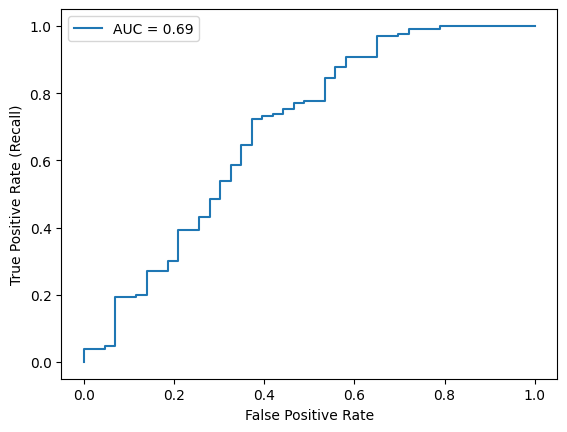

In [16]:
y_proba = model.predict(val_dataset).ravel()  # Utilisez .ravel() au lieu de [:,1]
y_true = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

fpr, tpr, thresholds = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc(fpr, tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

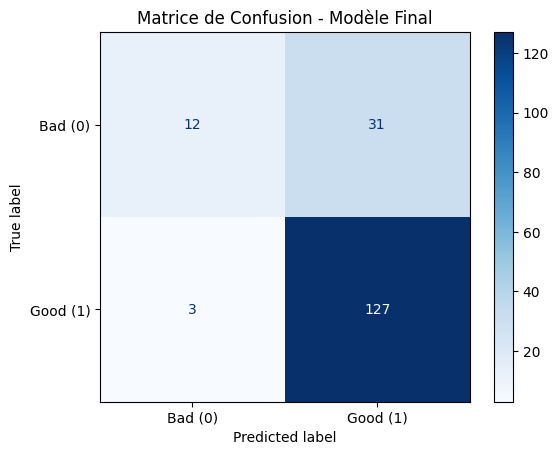

\nRapport de Classification :
              precision    recall  f1-score   support

     Bad (0)       0.80      0.28      0.41        43
    Good (1)       0.80      0.98      0.88       130

    accuracy                           0.80       173
   macro avg       0.80      0.63      0.65       173
weighted avg       0.80      0.80      0.77       173



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur l'ensemble de validation
y_pred = (y_proba > 0.5).astype(int)  # Seuil à 0.5 pour la classification binaire

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Calcul et affichage de la matrice
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad (0)', 'Good (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion - Modèle Final')
plt.show()

# Optionnel : Rapport de classification détaillé
from sklearn.metrics import classification_report
print("\\nRapport de Classification :")
print(classification_report(y_true, y_pred, target_names=['Bad (0)', 'Good (1)']))

In [24]:
optimal_threshold = 0.7
# Prédire les probabilités sur le dataset de test
y_test_proba = model.predict(test_dataset).ravel()  # Probabilités de la classe positive

# Appliquer le seuil optimal pour obtenir les prédictions binaires
y_test_pred = (y_test_proba > optimal_threshold).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [25]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Extraire les vraies étiquettes du dataset de test
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Calculer les métriques
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Afficher les résultats
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.7514
Test Recall: 0.8231
Test Precision: 0.8425
Test F1 Score: 0.8327
